In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from batch_plot import *
import seaborn as sns
import pickle
from matplotlib.colors import LinearSegmentedColormap, Normalize
from rdkit.Chem import rdFingerprintGenerator

/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### First, define some helper methods
These methods will allow us to compute assay logit predictions, cluster index predictions, and latent representations from an input array of smiles strings

In [3]:
def load_datum_from_run(run_dir, run_id, remove_duplicates=True, save_fps=True):
    run_path = os.path.join(run_dir, run_id)
    if not os.path.exists(run_path):
        print(f"Run {run_id} does not exist")
        return None
    values = sqlite_load(f"{run_path}/train/", sqlite_cols, 1)
    smis, rewards = np.array(values['smi'][0]), np.array(values['fr_0'][0])
    original_len = len(smis)
    fps_file = os.path.join(run_path, "fps.npy")

    if remove_duplicates:
        smis, idx = np.unique(smis, return_index=True)
        rewards = rewards[idx]
        print(f"Removed {original_len - len(smis)} duplicates")

    if os.path.exists(fps_file):
        fps = np.load(fps_file)
        fps = list(map(get_fp_from_base64, fps))
        if len(fps) == original_len and remove_duplicates:
            fps = [fps[i] for i in idx]
        assert len(fps) == len(smis), f"fps len {len(fps)} != smis len {len(smis)}"
        print(f"Loaded fps from {fps_file}!")
    else:
        print("Generating fps...")
        fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
        mols = list(map(Chem.MolFromSmiles, tqdm(smis)))
        fps = fpgen.GetFingerprints(mols, numThreads=8)
        if save_fps:
            print("Saving fps to file...")
            to_save_fps = np.array([x.ToBase64() for x in tqdm(fps)])
            np.save(fps_file, to_save_fps)
            print(f"Saved fps to {fps_file}")
    
    return fps, rewards, smis

def load_puma_dataset_fps(smis, save_fps=True):
    data_dir = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/data"
    try:
        fps = np.load(f"{data_dir}/puma_fingerprints.npy", allow_pickle=True)
        fps = list(map(get_fp_from_base64, fps))
    except FileNotFoundError:
        fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        mols = list(map(Chem.MolFromSmiles, tqdm(smis)))
        fps = fpgen.GetFingerprints(mols, numThreads=8)
        if save_fps:
            to_save_fps = np.array([x.ToBase64() for x in tqdm(fps)])
            np.save(f"{data_dir}/puma_fingerprints.npy", to_save_fps)
    return fps

def predict_assay_logits_from_smi(run_path, smis, assay_model, target_active_assay_cols, save_preds=True):
    if target_active_assay_cols is None or len(target_active_assay_cols) == 0: return []
    try:
        if run_path is None: raise FileNotFoundError
        logit_values = np.load(f"{run_path}/assay_preds.npy")
        print(f"Loaded assay preds from {run_path}/assay_preds.npy")
    except FileNotFoundError:
        full_df = pd.DataFrame(smis, columns=["smiles"])
        dataset = TestDataset(full_df, mol_col="smiles", label_col=None)
        dataloader = make_eval_data_loader(dataset, batch_size=2048)
        y_hat = []
        for batch in tqdm(dataloader):
            y_hat.append(assay_model(batch)[0].detach().cpu().numpy())
        y_hat = np.vstack(y_hat)
        logit_values = y_hat[:, target_active_assay_cols.tolist()].squeeze()
        if save_preds:
            np.save(f"{run_path}/assay_preds.npy", logit_values)
            print(f"Saved assay preds to {run_path}/assay_preds.npy")
    print(logit_values.shape)
    return logit_values

def predict_cluster_logits_from_smi(run_path, smis, cluster_model, target_cluster_col, save_preds=True):
    if target_cluster_col is None: return []
    try:
        if run_path is None: raise FileNotFoundError
        y_hat = np.load(f"{run_path}/cluster_preds.npy")
        print(f"Loaded cluster preds from {run_path}/cluster_preds.npy")
    except FileNotFoundError:
        full_df = pd.DataFrame(smis, columns=["smiles"])
        dataset = TestDataset(full_df, mol_col="smiles", label_col=None)
        dataloader = make_eval_data_loader(dataset, batch_size=2048)
        y_hat = []
        for batch in tqdm(dataloader):
            y_hat.append(cluster_model(batch)[0].detach().cpu().numpy())
        y_hat = np.vstack(y_hat)
        if save_preds:
            np.save(f"{run_path}/cluster_preds.npy", y_hat)
            print(f"Saved cluster preds to {run_path}/cluster_preds.npy")
    logit_values = y_hat[:, target_cluster_col].squeeze()
    print(logit_values.shape)
    return logit_values

def predict_latents_from_smi(cfg, smis, mmc_model=None):
    mmc_model = load_mmc_model(cfg) if mmc_model is None else mmc_model
    graphs = [mol2graph(Chem.MolFromSmiles(smi)) for smi in tqdm(smis)]
    preds = []
    batch_size = 2048
    for i in range(0, len(graphs), batch_size):
        batch = gd.Batch.from_data_list([i for i in graphs[i:i+batch_size] if i is not None])
        batch.to(mmc_model.device if hasattr(mmc_model, 'device') else device)
        pred = mmc_model({"inputs": {"struct": batch}}, mod_name="struct")
        pred = pred.data.cpu().detach().numpy()
        preds.append(pred)
    return np.vstack(preds)

def select_from(array, indices):
    if type(array) is list:
        return [array[i] for i in indices]
    return array[indices]

def remove_duplicates_from_run(run_datum):
    original_len = len(run_datum['smis'])
    smis, idx = np.unique(run_datum['smis'], return_index=True)
    print(f"Removed {original_len - len(smis)} duplicates")
    run_datum = {
        k: select_from(v, idx) for k, v in run_datum.items()
        if type(v) not in [int, float, str]
    }
    return run_datum

def find_modes_from_run_datum(run_datum, sim_threshold=0.4, k=100, reward_threshold=None):
    "Returns the indices of the top-k modes in the run_datum"
    sorted_idx = np.argsort(run_datum['rewards'])[::-1]
    modes_idx, modes_fps = [sorted_idx[0]], [run_datum['fps'][sorted_idx[0]]]
    for idx in tqdm(sorted_idx):
        if reward_threshold and run_datum['rewards'][idx] < reward_threshold: continue
        if len(modes_idx) >= k: break
        fp = run_datum['fps'][idx]
        if is_new_mode(modes_fps, fp, sim_threshold=sim_threshold):
            modes_fps.append(fp)
            modes_idx.append(idx)
    return modes_idx

def num_modes_over_trajs(run_datum, rew_thresh=0.9, sim_thresh=0.4, batch_size=64):
    "Returns the overall number of modes found over the trajectories"
    rewards, fps, smis = run_datum['rewards'], run_datum['fps'], run_datum['smis']
    num_traj = len(rewards) // batch_size
    num_modes_in_each_traj, modes_fps = np.zeros(num_traj), []
    num_unique_scafs, unique_scafs = np.zeros(num_traj), []
    for i in tqdm(range(num_traj)):
        start, end = i * batch_size, (i + 1) * batch_size
        for r, fp, smi in zip(rewards[start:end], fps[start:end], smis[start:end]):
            # scaf = Chem.MolToSmiles(MakeScaffoldGeneric(Chem.MolFromSmiles(smi)))
            if r >= rew_thresh and is_new_mode(modes_fps, fp, sim_threshold=sim_thresh):
                modes_fps.append(fp)
                num_modes_in_each_traj[i] += 1
            # if scaf not in unique_scafs:
                # unique_scafs.append(scaf)
                # num_unique_scafs[i] += 1
    num_modes_overall = np.cumsum(num_modes_in_each_traj)
    num_scafs_overall = np.cumsum(num_unique_scafs)
    return num_modes_overall, num_scafs_overall

def load_target_from_path(target_path, mmc_model, target_mode="morph"):
    with open(target_path, "rb") as f:
        target = pickle.load(f)
    target_smi = target['inputs']['struct'].mols.decode('utf-8')
    target["inputs"]["morph"] = target["inputs"]["morph"][None, ...]
    target["inputs"]["joint"]["morph"] = target["inputs"]["joint"]["morph"][None, ...]
    target["inputs"] = to_device(target["inputs"], device=device)
    with torch.no_grad():
        morph_latent = mmc_model(target, mod_name="morph").cpu().numpy().reshape(1, -1)
        struct_latent = mmc_model(target, mod_name="struct").cpu().numpy().reshape(1, -1)
        joint_latent = mmc_model(target, mod_name="joint").cpu().numpy().reshape(1, -1)

    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    target_fp = fpgen.GetFingerprint(Chem.MolFromSmiles(target_smi))
    target_latent = morph_latent if target_mode == "morph" else joint_latent
    target_reward = cosine_similarity(struct_latent, target_latent)[0][0]
    return target_smi, target_fp, struct_latent, morph_latent, joint_latent, target_reward
    

### Next, we define constants that will be used throughout the notebook
These constants include the target sample index, the corresponding run_path(s) that contains the generated samples for our gflownet method as well as reference methods such as random sampling and RL benchmarks

In [4]:
target_idx = 1847
target_mode = "joint"
target_sample_path = f"/home/mila/s/stephen.lu/gfn_gene/res/mmc/targets/sample_{target_idx}.pkl"
runs_dir = "/home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps"
run_paths = {
    "GFN(32)": "05-02-04-48-morph-sim-run-guided-high-temp/hearty-sweep-43-id-9hlis9sz",
    "GFN(16)": "05-02-04-36-morph-sim-run-guided-high-temp/playful-sweep-11-id-bs4515ny",
    "GFN(1)": "04-30-04-14-morph-sim-run-with-dataset/frosty-sweep-27-id-4fdd0n63",
    "GFN(0)": "04-30-03-24-morph-sim-run-with-dataset/sandy-sweep-11-id-njg67az5",
    "RND": "04-30-02-22-morph-sim-run-random-baselines/summer-sweep-20-id-4skmh10v",
}

### Now, we obtain datum for the target sample as well as for the PUMA dataset, which will be used as reference data for many of our plots
These datum include the target latent representations, the target cluster/assay pred, the PUMA test set samples, PUMA test set cluster/assay preds, assay pred model, cluster pred model, etc.

In [8]:
# Get full PUMA dataset latents, fingerprints, and smiles
datamodule, cfg = setup_puma()
representations = get_representations()
dataset_smis = np.array([x["inputs"]["struct"].mols for x in datamodule.dataset])
dataset_fps = load_puma_dataset_fps(dataset_smis, save_fps=True)

# Load models and ground truth data
assay_dataset = load_assay_matrix_from_csv()
assay_model = load_assay_pred_model()
cluster_labels = load_cluster_labels_from_csv()
cluster_model = load_cluster_pred_model()
mmc_model = load_mmc_model(cfg)

# Load target fingerprint, smiles, latents, active assay cols (if any)
target_smi, target_fp, target_struct_latent, target_morph_latent, target_joint_latent, target_reward =\
    load_target_from_path(target_sample_path, mmc_model, target_mode=target_mode)
target_active_assay_cols = get_active_assay_cols(assay_dataset, target_smi)
target_cluster_id = cluster_labels.loc[target_smi]["cluster"]
target_latent = target_morph_latent if target_mode == "morph" else target_joint_latent

# Infer target & dataset reward, target assay logits, and target cluster logits
target_latent = target_morph_latent if target_mode == "morph" else target_joint_latent
target_reward = cosine_similarity(target_struct_latent, target_latent)[0][0]
dataset_rewards = ((cosine_similarity(representations['struct'], target_latent) + 1) / 2).reshape(-1,)
dataset_sim_to_target = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, dataset_fps))
target_assay_preds = predict_assay_logits_from_smi(None, [target_smi], assay_model, target_active_assay_cols, save_preds=False)
target_active_cluster_pred = predict_cluster_logits_from_smi(None, [target_smi], cluster_model, target_cluster_id, save_preds=False)

print(f"Target struct~{target_mode} alignment: ", target_reward)
print(f"Target assay predicted logits: ", target_assay_preds)
print(f"Target cluster {target_cluster_id} active logit: ", target_active_cluster_pred)

shuffled_scaffold


INFO:deepchem.splits.splitters:About to generate scaffolds
INFO:deepchem.splits.splitters:Generating scaffold 0/16961


Train on samples from shuffled_scaffold.


INFO:deepchem.splits.splitters:Generating scaffold 1000/16961
INFO:deepchem.splits.splitters:Generating scaffold 2000/16961
INFO:deepchem.splits.splitters:Generating scaffold 3000/16961
INFO:deepchem.splits.splitters:Generating scaffold 4000/16961
INFO:deepchem.splits.splitters:Generating scaffold 5000/16961
INFO:deepchem.splits.splitters:Generating scaffold 6000/16961
INFO:deepchem.splits.splitters:Generating scaffold 7000/16961
INFO:deepchem.splits.splitters:Generating scaffold 8000/16961
INFO:deepchem.splits.splitters:Generating scaffold 9000/16961
INFO:deepchem.splits.splitters:Generating scaffold 10000/16961
INFO:deepchem.splits.splitters:Generating scaffold 11000/16961
INFO:deepchem.splits.splitters:Generating scaffold 12000/16961
INFO:deepchem.splits.splitters:Generating scaffold 13000/16961
INFO:deepchem.splits.splitters:Generating scaffold 14000/16961
INFO:deepchem.splits.splitters:Generating scaffold 15000/16961
INFO:deepchem.splits.splitters:Generating scaffold 16000/16961
I

Train on 13568 samples.
Validate on 1696 samples.
Test on 1697 samples.


INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(
100%|██████████| 1/1 [00:00<00:00, 375.30it/s]


()


100%|██████████| 1/1 [00:00<00:00, 218.70it/s]

()
Target struct~joint alignment:  0.9234221
Target assay predicted logits:  0.23693313
Target cluster 1 active logit:  0.86416656


### Now we load the datum for each run inside run_paths. Datum include the following:
- smiles
- rewards
- fingerprints
- tanimoto similarity to target
- cluster logit predictions (TODO)
- assay logit predictions (for active assay target cols, if any)

We also add the datum for the puma dataset splits into the datum dictionary

In [6]:
runs_datum = {}
for run_name, run_id in run_paths.items():
    run_path = os.path.join(runs_dir, run_id)
    fps, rewards, smis = load_datum_from_run(runs_dir, run_id, remove_duplicates=False)
    tani_sim_to_target = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, fps))
    assay_preds = predict_assay_logits_from_smi(run_path, smis, assay_model, target_active_assay_cols)
    cluster_preds = predict_cluster_logits_from_smi(run_path, smis, cluster_model, target_cluster_id)
    run_datum = {
        "path": run_path,
        "fps": fps,
        "rewards": rewards,
        "smis": smis,
        'sim_to_target': tani_sim_to_target,
        'assay_preds': assay_preds,
        'cluster_preds': cluster_preds,
    }
    runs_datum[run_name] = run_datum

320000it [00:04, 73346.37it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-02-04-48-morph-sim-run-guided-high-temp/hearty-sweep-43-id-9hlis9sz/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-02-04-48-morph-sim-run-guided-high-temp/hearty-sweep-43-id-9hlis9sz/assay_preds.npy
(320000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-02-04-48-morph-sim-run-guided-high-temp/hearty-sweep-43-id-9hlis9sz/cluster_preds.npy
(320000,)


480000it [00:05, 91366.71it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-02-04-36-morph-sim-run-guided-high-temp/playful-sweep-11-id-bs4515ny/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-02-04-36-morph-sim-run-guided-high-temp/playful-sweep-11-id-bs4515ny/assay_preds.npy
(480000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-02-04-36-morph-sim-run-guided-high-temp/playful-sweep-11-id-bs4515ny/cluster_preds.npy
(480000,)


630000it [00:04, 143518.80it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-04-14-morph-sim-run-with-dataset/frosty-sweep-27-id-4fdd0n63/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-04-14-morph-sim-run-with-dataset/frosty-sweep-27-id-4fdd0n63/assay_preds.npy
(630000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-04-14-morph-sim-run-with-dataset/frosty-sweep-27-id-4fdd0n63/cluster_preds.npy
(630000,)


640000it [00:01, 373201.36it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-03-24-morph-sim-run-with-dataset/sandy-sweep-11-id-njg67az5/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-03-24-morph-sim-run-with-dataset/sandy-sweep-11-id-njg67az5/assay_preds.npy
(640000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-03-24-morph-sim-run-with-dataset/sandy-sweep-11-id-njg67az5/cluster_preds.npy
(640000,)


640000it [00:02, 217993.03it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-02-22-morph-sim-run-random-baselines/summer-sweep-20-id-4skmh10v/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-02-22-morph-sim-run-random-baselines/summer-sweep-20-id-4skmh10v/assay_preds.npy
(640000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-02-22-morph-sim-run-random-baselines/summer-sweep-20-id-4skmh10v/cluster_preds.npy
(640000,)


In [9]:
train_idx, val_idx, test_idx = datamodule.get_split_idx()
dataset_assay_preds = predict_assay_logits_from_smi(None, dataset_smis, assay_model, target_active_assay_cols, save_preds=False)
dataset_cluster_preds = predict_cluster_logits_from_smi(None, dataset_smis, cluster_model, target_cluster_id, save_preds=False)
runs_datum['PUMA_tr'] = {
    "fps": [dataset_fps[i] for i in train_idx],
    "rewards": dataset_rewards[train_idx],
    "smis": dataset_smis[train_idx],
    "sim_to_target": dataset_sim_to_target[train_idx],
    "cluster_preds": dataset_cluster_preds[train_idx],
    "assay_preds": dataset_assay_preds[train_idx] if len(target_active_assay_cols) == 1 else dataset_assay_preds[train_idx,:],
}
runs_datum['PUMA_val'] = {
    "fps": [dataset_fps[i] for i in val_idx],
    "rewards": dataset_rewards[val_idx],
    "smis": dataset_smis[val_idx],
    'sim_to_target': dataset_sim_to_target[val_idx],
    "cluster_preds": dataset_cluster_preds[val_idx],
    "assay_preds": dataset_assay_preds[val_idx] if len(target_active_assay_cols) == 1 else dataset_assay_preds[val_idx,:],
}
runs_datum['PUMA_test'] = {
    "fps": [dataset_fps[i] for i in test_idx],
    "rewards": dataset_rewards[test_idx],
    "smis": dataset_smis[test_idx],
    'sim_to_target': dataset_sim_to_target[test_idx],
    "cluster_preds": dataset_cluster_preds[test_idx],
    "assay_preds": dataset_assay_preds[test_idx] if len(target_active_assay_cols) == 1 else dataset_assay_preds[test_idx,:],
}

 11%|█         | 1/9 [00:03<00:26,  3.32s/it]

100%|██████████| 9/9 [00:23<00:00,  2.61s/it]


(16961,)


100%|██████████| 9/9 [00:30<00:00,  3.35s/it]

(16961,)


### Bin samples by column with partial ordering
For many of the plots below, we will need to plot values binned by reward or by Tanimoto similarity to target. We will compute these bins right now and save the indices for each bin in the datum so that it is easy to plot these values later on.

In [15]:
def pool_datum(runs_datum, avoid_keys=None):
    pooled_datum = {'pooled': {}}
    for run_name, run_datum in runs_datum.items():
        if run_name in avoid_keys: continue
        for key, value in run_datum.items():
            if key not in pooled_datum['pooled']:
                pooled_datum['pooled'][key] = value
            elif type(value) == list:
                pooled_datum['pooled'][key].extend(value)
            else:
                pooled_datum['pooled'][key] = np.concatenate([pooled_datum['pooled'][key], value])
    return pooled_datum

def bin_datum_by_col(bin_col: str, datum, k_bins: int, return_bins=False,
                     samples_per_method=None, toss_bins_with_less_methods=False):
    # First, we assert that the bin_col is present among all the runs
    for run_name, run_datum in datum.items():
        assert bin_col in run_datum.keys(), f"{bin_col} not found in {run_name} keys"
    # Next, we find the min and max among all runs in the datum for the bin_col
    min_val = min([min(run_datum[bin_col]) for run_datum in datum.values()])
    max_val = max([max(run_datum[bin_col]) for run_datum in datum.values()])
    # We then create k bins between min and max
    bins = np.linspace(min_val, max_val, k_bins)
    # Finally, for each run, we save the bin index for each data point
    print(f"Binning {bin_col} into {k_bins} bins between {min_val} and {max_val}: ")
    print(f"Bins: {bins}")
    datum_bins = {}
    for run_name, run_datum in datum.items():
        bin_indices = np.digitize(run_datum[bin_col], bins)
        datum_bins[run_name] = bin_indices
    # Finally, we compute the bins if return_bins is True, or just return the bin indices
    if not return_bins:
        return datum_bins, bins
    # if samples_per_method is 'auto', we sample the same number of samples per method per bin
    if samples_per_method == 'auto':
        mode = min if toss_bins_with_less_methods else max
        mode_samples_per_bin = [
            mode([ len(np.where(datum_bins[run_name] == i)[0]) for run_name in datum.keys() ])
            for i in range(1, k_bins)
        ]
        samples_per_method = min([x for x in mode_samples_per_bin if x != 0])
    print(f"Sampling {samples_per_method} samples per method per bin")
    binned_datum = {}
    empty_bins = [False] * k_bins
    samples_per_bin = [0] * k_bins
    for run_name, run_datum in datum.items():
        binned_datum[run_name] = {}
        for i in range(1, k_bins+1):
            if empty_bins[i-1]: continue
            idx = np.where(datum_bins[run_name] == i)[0]
            if samples_per_method:
                idx = idx[np.random.choice(len(idx), size=min(samples_per_method, len(idx)), replace=False)]
                if len(idx) < samples_per_method:
                    if toss_bins_with_less_methods: empty_bins[i-1] = True
                    continue
            samples_per_bin[i-1] += len(idx)
            binned_datum[run_name][i] = {
                k: [v[j] for j in idx]
                for k, v in run_datum.items()
            }
    empty_bins = [x for x in range(1,k_bins+1) if empty_bins[x-1] == True]
    return binned_datum, bins, empty_bins, samples_per_bin

# Plots
## 1. Reward, Tanimoto Similarity, and UMAP plots
In this first section, we produce plots that don't require an additional oracle. These include:
- Number of modes over number of trajectories during training
- Number of unique scaffolds over number of trajectories during training (currently takes v long)
- Tanimoto similarity between top-k highest reward molecules during training
- Tanimoto similarity to target of top-k modes during training
- Normalized histogram of rewards for generated samples during training
- Normalized histogram of Tanimoto similarity to target for training samples
- UMAP of top-k modes coloured (more intensely) by reward obtained during training
- Normalized violin plot of Tanimoto similarity to target by binned reward
- Normalized violin plot of reward by binned Tanimoto similarity to target

 24%|██▍       | 2399/9843 [00:00<00:00, 11548.06it/s]

100%|██████████| 10000/10000 [00:01<00:00, 7240.24it/s]


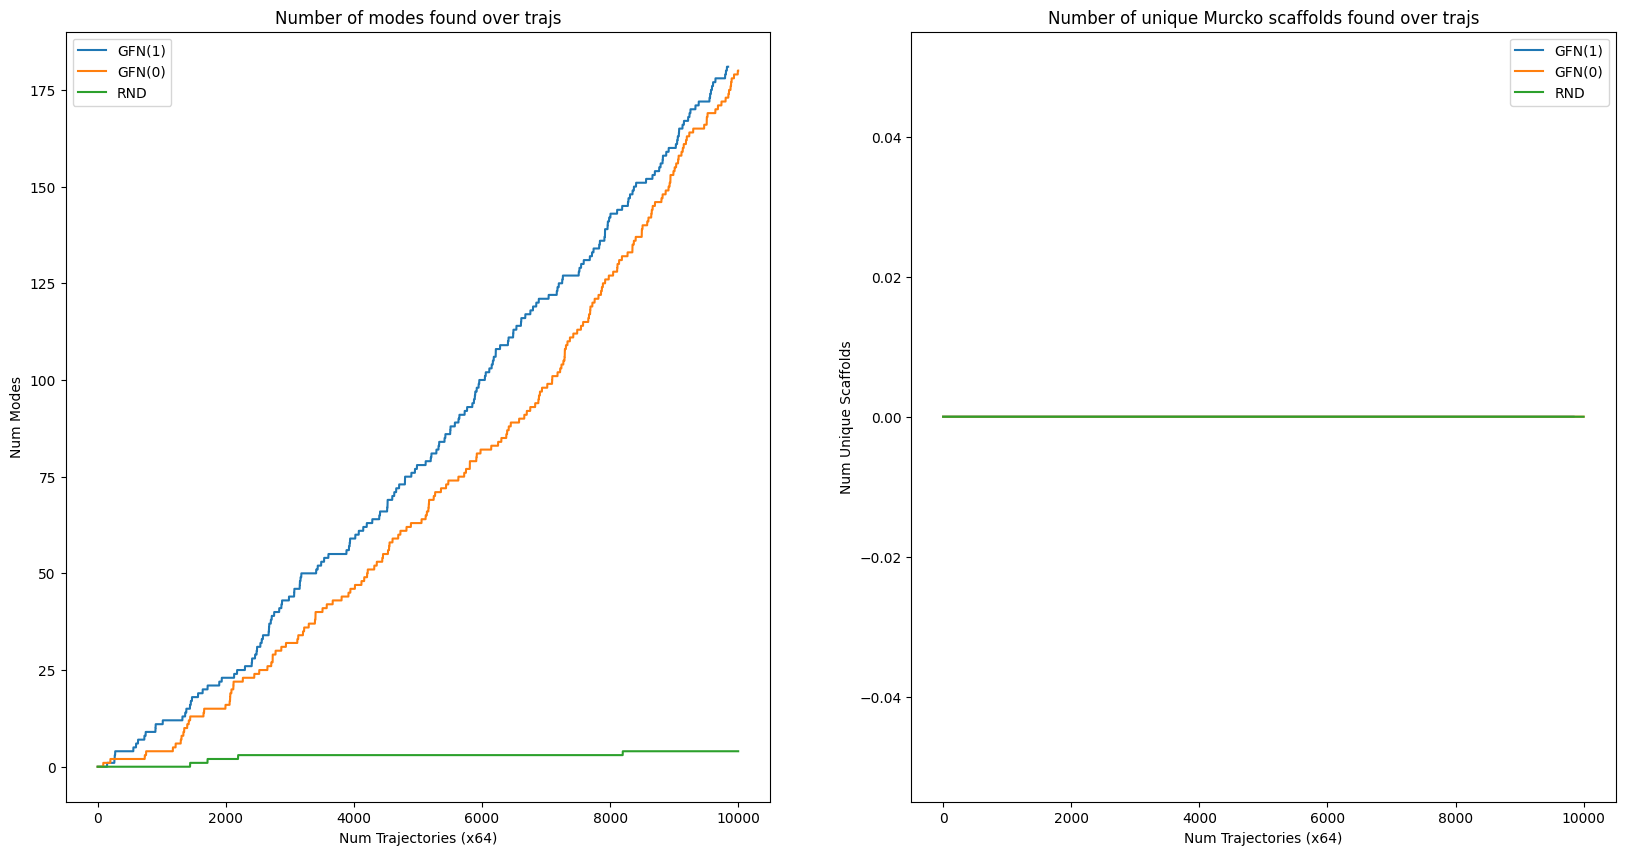

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for run_name, run_datum in runs_datum.items():
    if "PUMA" in run_name: continue
    num_modes, num_scafs = num_modes_over_trajs(run_datum, rew_thresh=0.95, sim_thresh=0.7, batch_size=64)
    sns.lineplot(x=np.arange(len(num_modes)), y=num_modes, ax=ax[0], label=run_name)
    sns.lineplot(x=np.arange(len(num_scafs)), y=num_scafs, ax=ax[1], label=run_name)

ax[0].set_title("Number of modes found over trajs")
ax[1].set_title("Number of unique Murcko scaffolds found over trajs")
ax[0].set_xlabel("Num Trajectories (x64)")
ax[1].set_xlabel("Num Trajectories (x64)")
ax[0].set_ylabel("Num Modes")
ax[1].set_ylabel("Num Unique Scaffolds")
plt.legend()
plt.show()

### These are the only plots that require all molecules sampled during training. We can now subset to remove duplicates for the further analyses
This might take some time since we are converting all arrays to numpy arrays

In [10]:
runs_datum = {k: remove_duplicates_from_run(v) for k, v in runs_datum.items()}

Removed 47565 duplicates
Removed 22053 duplicates
Removed 579 duplicates
Removed 619 duplicates
Removed 309024 duplicates
Removed 0 duplicates
Removed 0 duplicates
Removed 0 duplicates


100%|██████████| 500/500 [00:00<00:00, 4623.90it/s]


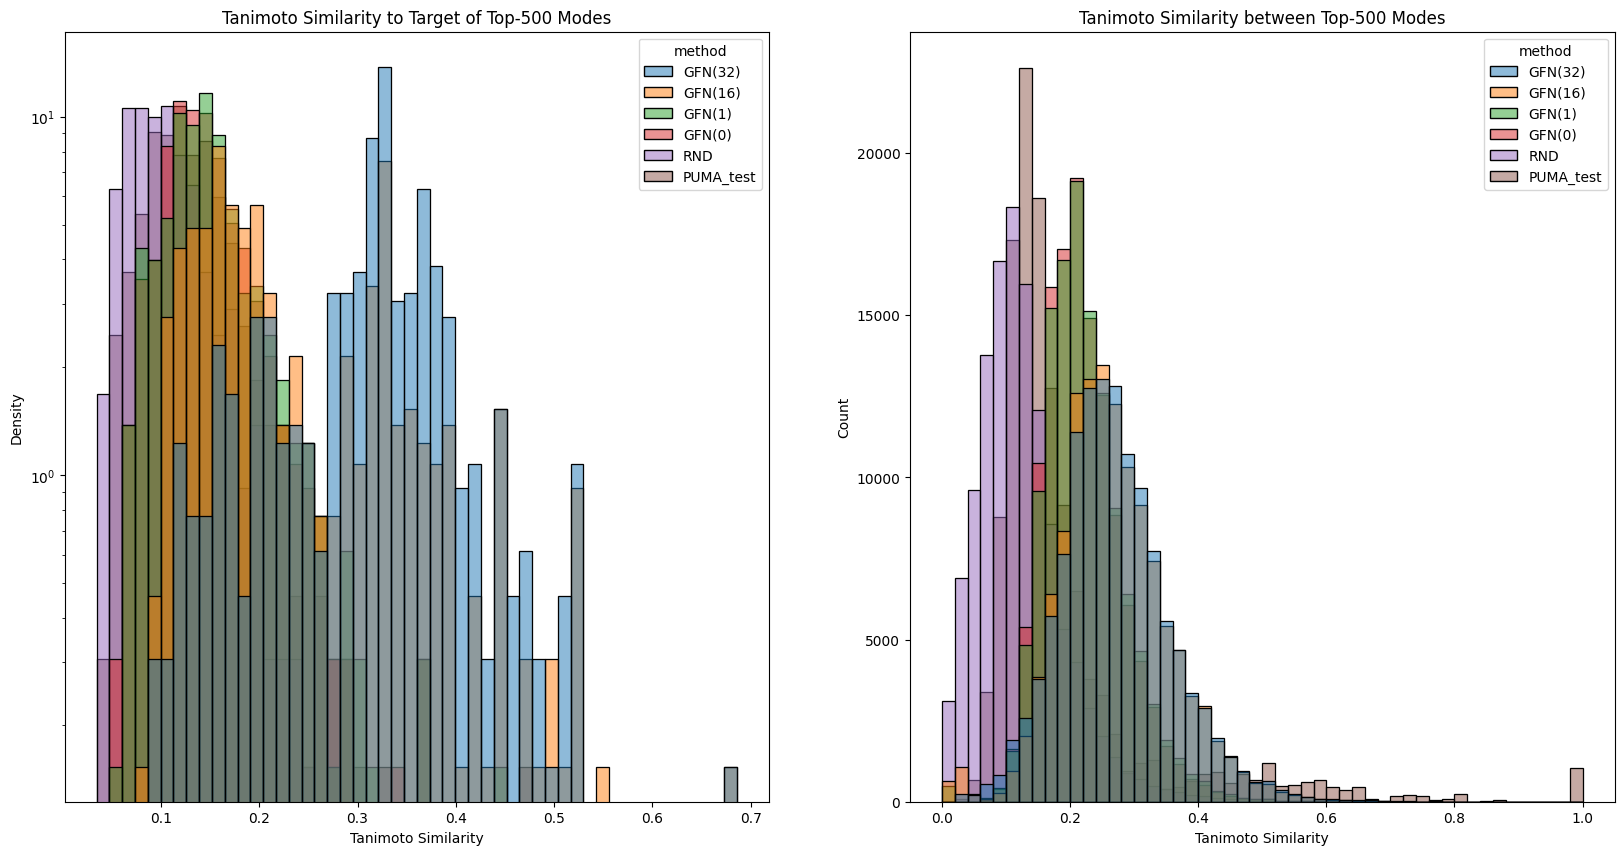

In [12]:
k = 500
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
df1, df2 = pd.DataFrame(), pd.DataFrame()
for run_name, run_datum in runs_datum.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    modes_idx = find_modes_from_run_datum(run_datum, sim_threshold=1.0, k=k)
    top_k_rewards_idx = np.argsort(run_datum['rewards'][modes_idx])[::-1][:k]
    modes_fps = [run_datum['fps'][i] for i in top_k_rewards_idx]
    tani_sim_between_modes = []
    for i in tqdm(range(len(modes_fps))):
        tani_sim_between_modes.extend(AllChem.DataStructs.BulkTanimotoSimilarity(modes_fps[i], modes_fps[i+1:]))

    df1 = pd.concat([df1, pd.DataFrame({
        "method": [run_name] * len(modes_idx),
        "sim_to_target": run_datum['sim_to_target'][modes_idx]
    })], ignore_index=True)
    df2 = pd.concat([df2, pd.DataFrame({
        "method": [run_name] * len(tani_sim_between_modes),
        "sim_between_modes": tani_sim_between_modes
    })], ignore_index=True)

sns.histplot(data=df1, x="sim_to_target", hue="method", bins=50, ax=ax[0], stat="density", common_norm=False, alpha=0.5)
sns.histplot(data=df2, x="sim_between_modes", hue="method", bins=50, ax=ax[1], stat="count", common_norm=False, alpha=0.5)
    
ax[0].set_title(f"Tanimoto Similarity to Target of Top-{k} Modes")
ax[0].set_xlabel("Tanimoto Similarity")
ax[1].set_title(f"Tanimoto Similarity between Top-{k} Modes")
ax[1].set_xlabel("Tanimoto Similarity")
ax[0].set_yscale('log', base=10)
plt.show()

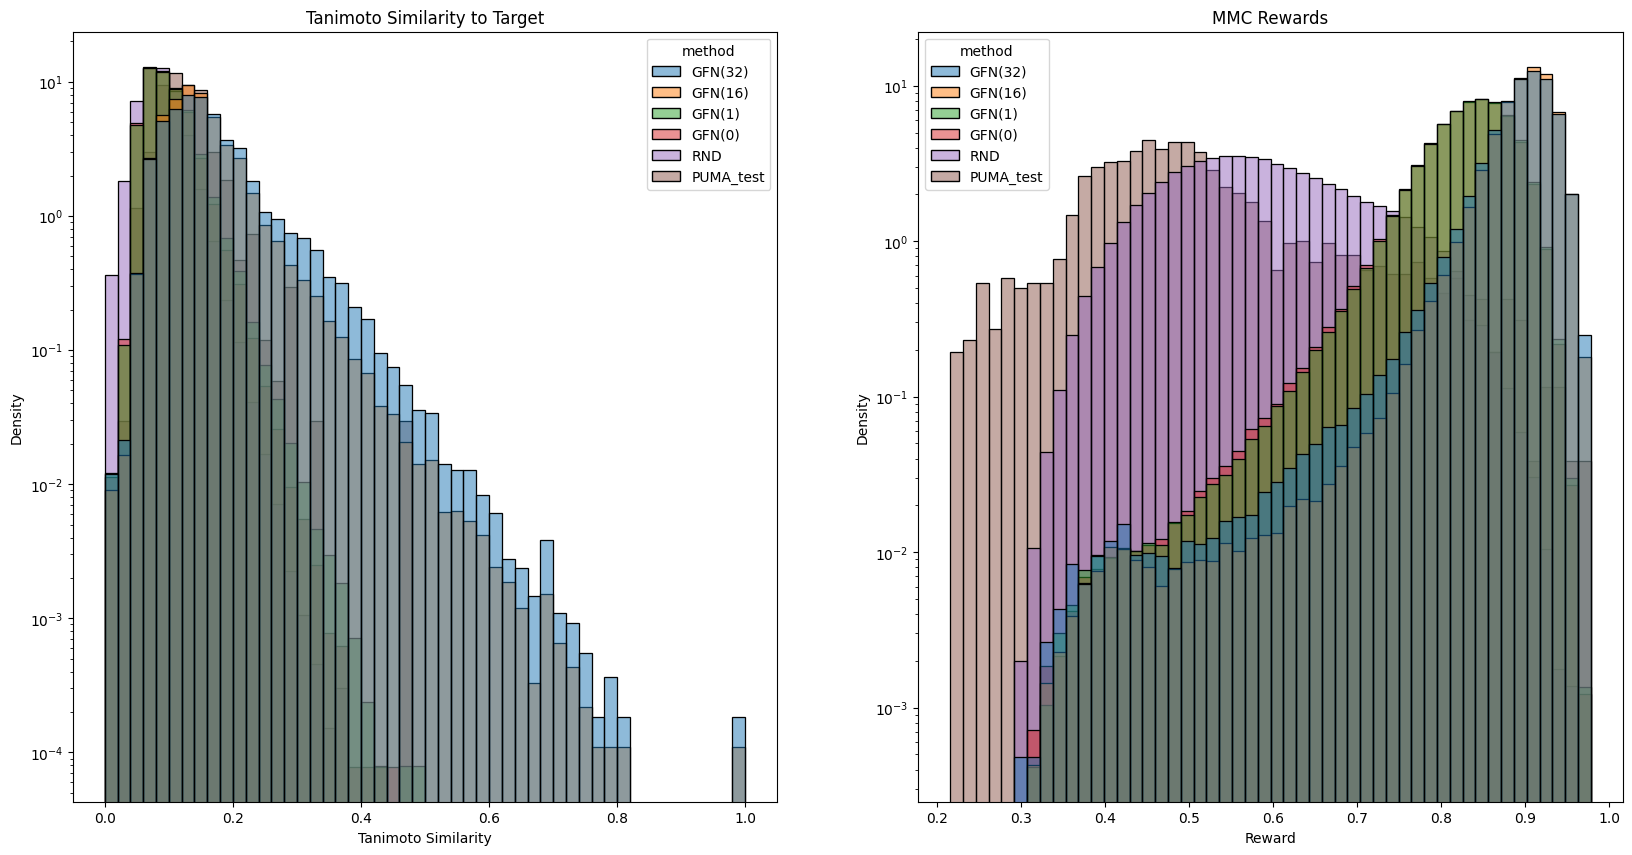

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
df = pd.DataFrame()
for run_name, run_datum in runs_datum.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    df = pd.concat([df, pd.DataFrame({
        "method": [run_name] * len(run_datum['rewards']),
        "rewards": run_datum['rewards'],
        "sim_to_target": run_datum['sim_to_target']
    })], ignore_index=True)

sns.histplot(data=df, x="sim_to_target", hue="method", bins=50, ax=ax[0], stat='density', common_norm=False)
sns.histplot(data=df, x="rewards", hue="method", bins=50, ax=ax[1], stat='density', common_norm=False)

ax[0].set_title("Tanimoto Similarity to Target")
ax[1].set_title("MMC Rewards")
ax[0].set_xlabel("Tanimoto Similarity")
ax[1].set_xlabel("Reward")
ax[0].set_yscale('log')
ax[1].set_yscale('log')
plt.show()

  2%|▏         | 5082/330976 [00:14<15:47, 343.78it/s] 
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


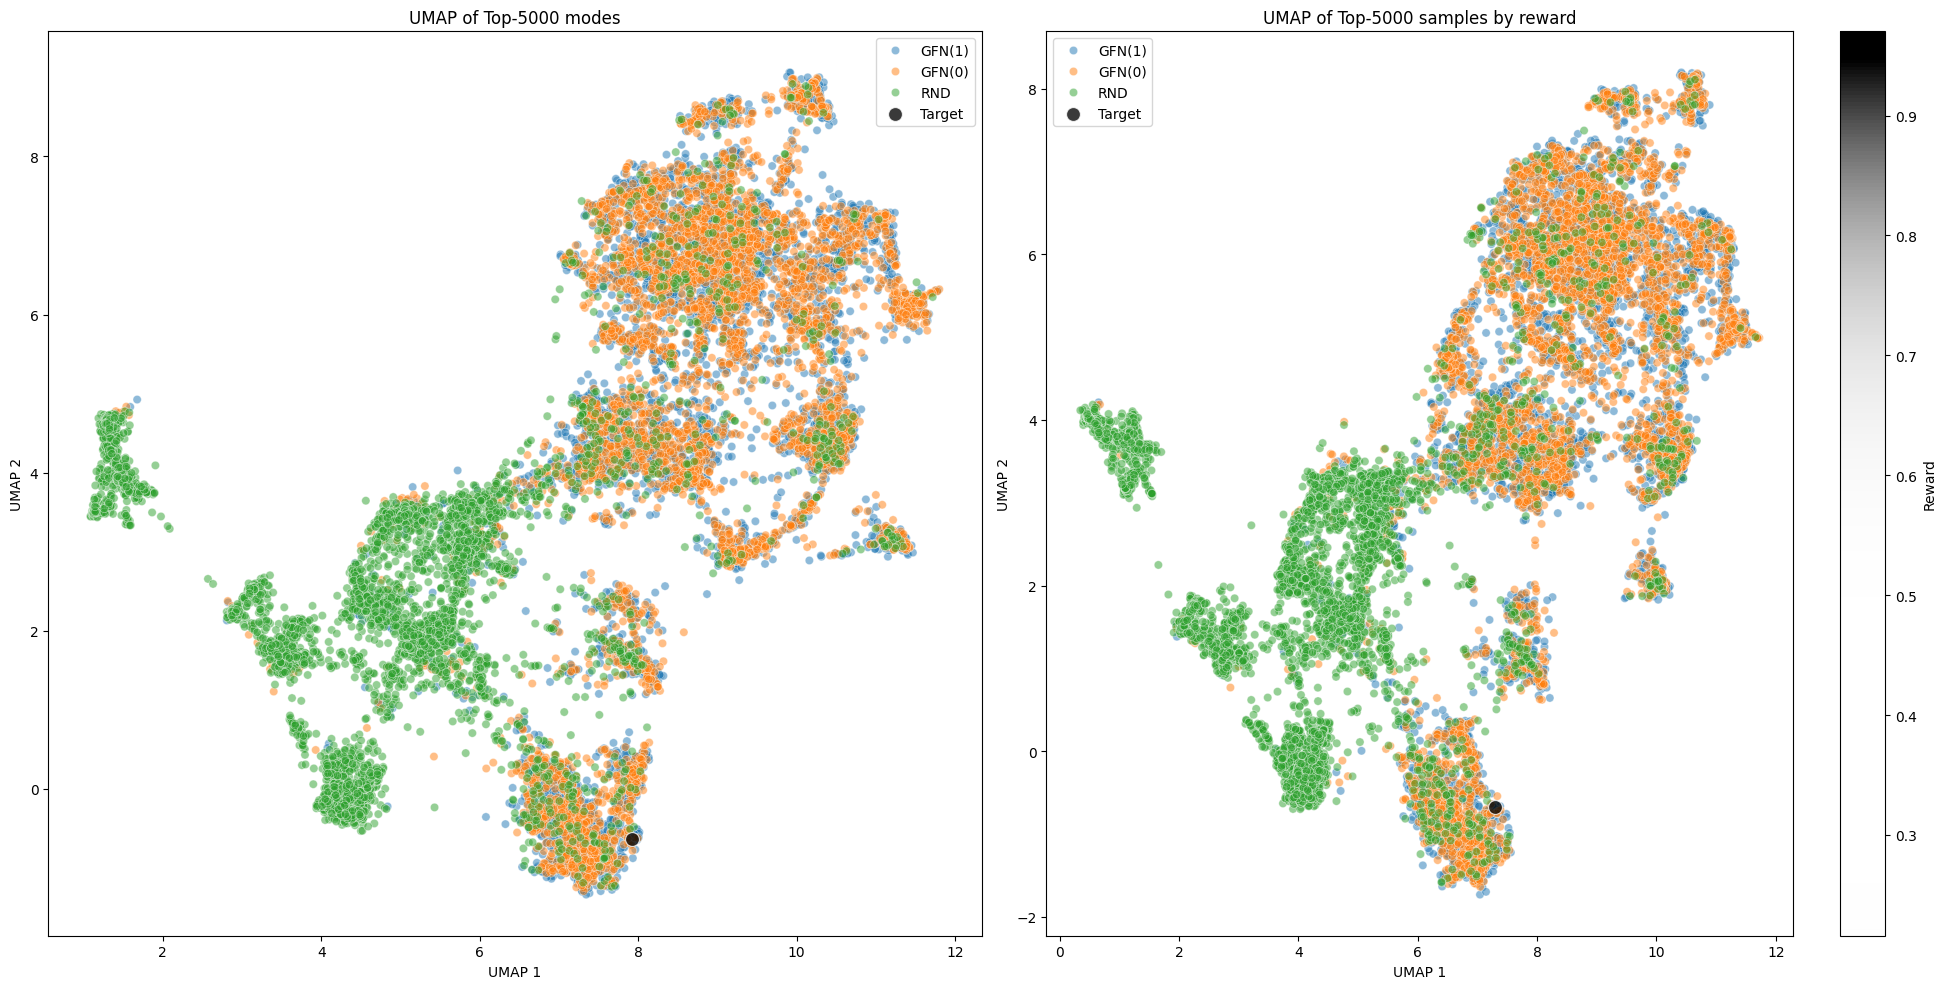

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
k = 5000
df1, df2 = pd.DataFrame(), pd.DataFrame()
# look at max_dist parameter
model = umap.UMAP(n_components=2, n_neighbors=15, random_state=42, verbose=False, min_dist=0.01, metric="euclidean")
max_reward = max([max(run_datum['rewards']) for run_datum in runs_datum.values()])
min_reward = min([min(run_datum['rewards']) for run_datum in runs_datum.values()])
norm_color_by_reward = lambda x: ((x - min_reward) / (max_reward - min_reward))**4
target_color = norm_color_by_reward(target_reward)

for run_name, run_datum in runs_datum.items():
    if run_name in ["PUMA_tr", "PUMA_val", "PUMA_test"]: continue
    rewards = run_datum['rewards']
    if run_name == "PUMA_test":
        top_k_modes_idx = np.arange(len(run_datum['fps']))
        top_k_rewards_idx = np.arange(len(run_datum['fps']))
    else:
        top_k_modes_idx = find_modes_from_run_datum(run_datum, sim_threshold=0.7, k=k)
        top_k_rewards_idx = np.argsort(rewards)[::-1][:k]

    df1 = pd.concat([df1, pd.DataFrame({
        "method": [run_name] * len(top_k_modes_idx),
        "fps": [run_datum['fps'][i] for i in top_k_modes_idx],
        "rewards": rewards[top_k_modes_idx],
        "alpha": list(map(norm_color_by_reward, rewards[top_k_modes_idx])),
    })], ignore_index=True)
    df2 = pd.concat([df2, pd.DataFrame({
        "method": [run_name] * len(top_k_rewards_idx),
        "fps": [run_datum['fps'][i] for i in top_k_rewards_idx],
        "rewards": rewards[top_k_rewards_idx],
        "alpha": list(map(norm_color_by_reward, rewards[top_k_rewards_idx])),
    })], ignore_index=True)

umap_top_modes = model.fit_transform(list(df1["fps"]))
target_umap = model.transform([target_fp])
df1["umap_0"], df1["umap_1"] = umap_top_modes[:,0], umap_top_modes[:,1]
sns.scatterplot(data=df1, x="umap_0", y="umap_1", hue="method", ax=ax[0], alpha=0.5)
sns.scatterplot(x=target_umap[:, 0], y=target_umap[:, 1], ax=ax[0], label="Target", color="black", s=100, alpha=target_color)

umap_top_rewards = model.fit_transform(list(df2["fps"]))
target_umap = model.transform([target_fp])
df2["umap_0"], df2["umap_1"] = umap_top_rewards[:,0], umap_top_rewards[:,1]
sns.scatterplot(data=df2, x="umap_0", y="umap_1", hue="method", ax=ax[1], alpha=0.5)
sns.scatterplot(x=target_umap[:, 0], y=target_umap[:, 1], ax=ax[1], label="Target", color="black", s=100, alpha=target_color)

ax[0].set_title(f"UMAP of Top-{k} modes")
ax[1].set_title(f"UMAP of Top-{k} samples by reward")
ax[0].set_xlabel("UMAP 1")
ax[0].set_ylabel("UMAP 2")
ax[1].set_xlabel("UMAP 1")
ax[1].set_ylabel("UMAP 2")

# add a colorbar that maps the reward to the color using the lambda function we defined above
norm = Normalize(vmin=min_reward, vmax=max_reward)
reward_to_rgba = lambda x: (0, 0, 0, norm_color_by_reward(x))
colors = [reward_to_rgba(norm(x)) for x in np.linspace(min_reward, max_reward, 100)]
cmap = LinearSegmentedColormap.from_list('reward_cmap', colors)

# Create a ScalarMappable object
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax[1], location="right")
cbar.set_label('Reward')

plt.tight_layout()
plt.show()

In [ ]:
# Create a pooled datum where we merge the datum for each run under a new key called 'pooled'
pooled_datum = pool_datum(runs_datum, avoid_keys=["PUMA_tr", "PUMA_val"])
binned_datum_by_reward, rew_bins, rew_empty_bins, sper_rew_bin = bin_datum_by_col(
    "rewards", pooled_datum, 10, return_bins=True, samples_per_method=1000, toss_bins_with_less_methods=True)
binned_datum_by_tan_sim, sim_bins, sim_empty_bins, sper_sim_bin = bin_datum_by_col(
    "sim_to_target", pooled_datum, 8, return_bins=True, samples_per_method=500, toss_bins_with_less_methods=True)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
global_df_by_rew = pd.DataFrame()
global_df_by_sim = pd.DataFrame()

for run_name, run_datum in binned_datum_by_reward.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    # df["method"] = run_name
    global_df_by_rew = pd.concat([global_df_by_rew, df], ignore_index=True)

rew_bins_ne = [i for i in range(1, len(rew_bins)+1) if i not in rew_empty_bins]
global_df_by_rew = global_df_by_rew[global_df_by_rew['Bin'].isin(rew_bins_ne)]
rew_bin_labels = [f"{rew_bins[i]:.2f}-{rew_bins[i+1]:.2f}\n({sper_rew_bin[i]})"
                    for i in range(len(rew_bins)-1)] + [f"{rew_bins[-1]:.2f}-1.0\n({sper_rew_bin[-1]})"]
sns.boxplot(x="Bin", y="sim_to_target", data=global_df_by_rew, ax=ax[0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)

for run_name, run_datum in binned_datum_by_tan_sim.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    # df["method"] = run_name
    global_df_by_sim = pd.concat([global_df_by_sim, df], ignore_index=True)

sim_bins_ne = [i for i in range(1, len(sim_bins)+1) if i not in sim_empty_bins]
global_df_by_sim = global_df_by_sim[global_df_by_sim['Bin'].isin(sim_bins_ne)]
sim_bin_labels = [f"{sim_bins[i]:.2f}-{sim_bins[i+1]:.2f}\n({sper_sim_bin[i]})"
                    for i in range(len(sim_bins)-1)] + [f"{sim_bins[-1]:.2f}-1.0\n({sper_sim_bin[-1]})"]
sns.boxplot(x="Bin", y="rewards", data=global_df_by_sim, ax=ax[1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

ax[0].set_title("Tanimoto Similarity to Target by Reward Bins")
ax[0].set_xlabel("Reward Bin")
ax[0].set_ylabel("Tanimoto Similarity")
ax[0].xaxis.set_tick_params(rotation=45)

ax[1].set_title("Reward by Tanimoto Similarity to Target Bins")
ax[1].set_xlabel("Tanimoto Similarity Bin")
ax[1].set_ylabel("Reward")
ax[1].xaxis.set_tick_params(rotation=45)

plt.show()

## 2. Assay and Cluster Prediction Plots
In this section, we produce plots that require an additional oracle. These include:
- Normalized histogram of active target assay predictions for training samples
- Regular histogram of active target assay predictions for top-k modes
- Normalized histogram of active target cluster predictions for training samples
- Regular histogram of active target cluster predictions for top-k modes
- Violin plot of active target assay predictions by binned reward
- Violin plot of active target assay predictions by binned Tanimoto similarity to target
- Violin plot of active target cluster predictions by binned reward
- Violin plot of active target cluster predictions by binned Tanimoto similarity

  0%|          | 1002/457947 [00:00<02:48, 2705.90it/s]


GFN(16): 1000


  0%|          | 1000/330976 [00:00<02:07, 2593.20it/s]


RND: 1000


100%|██████████| 1697/1697 [00:00<00:00, 4331.14it/s]


PUMA_test: 513


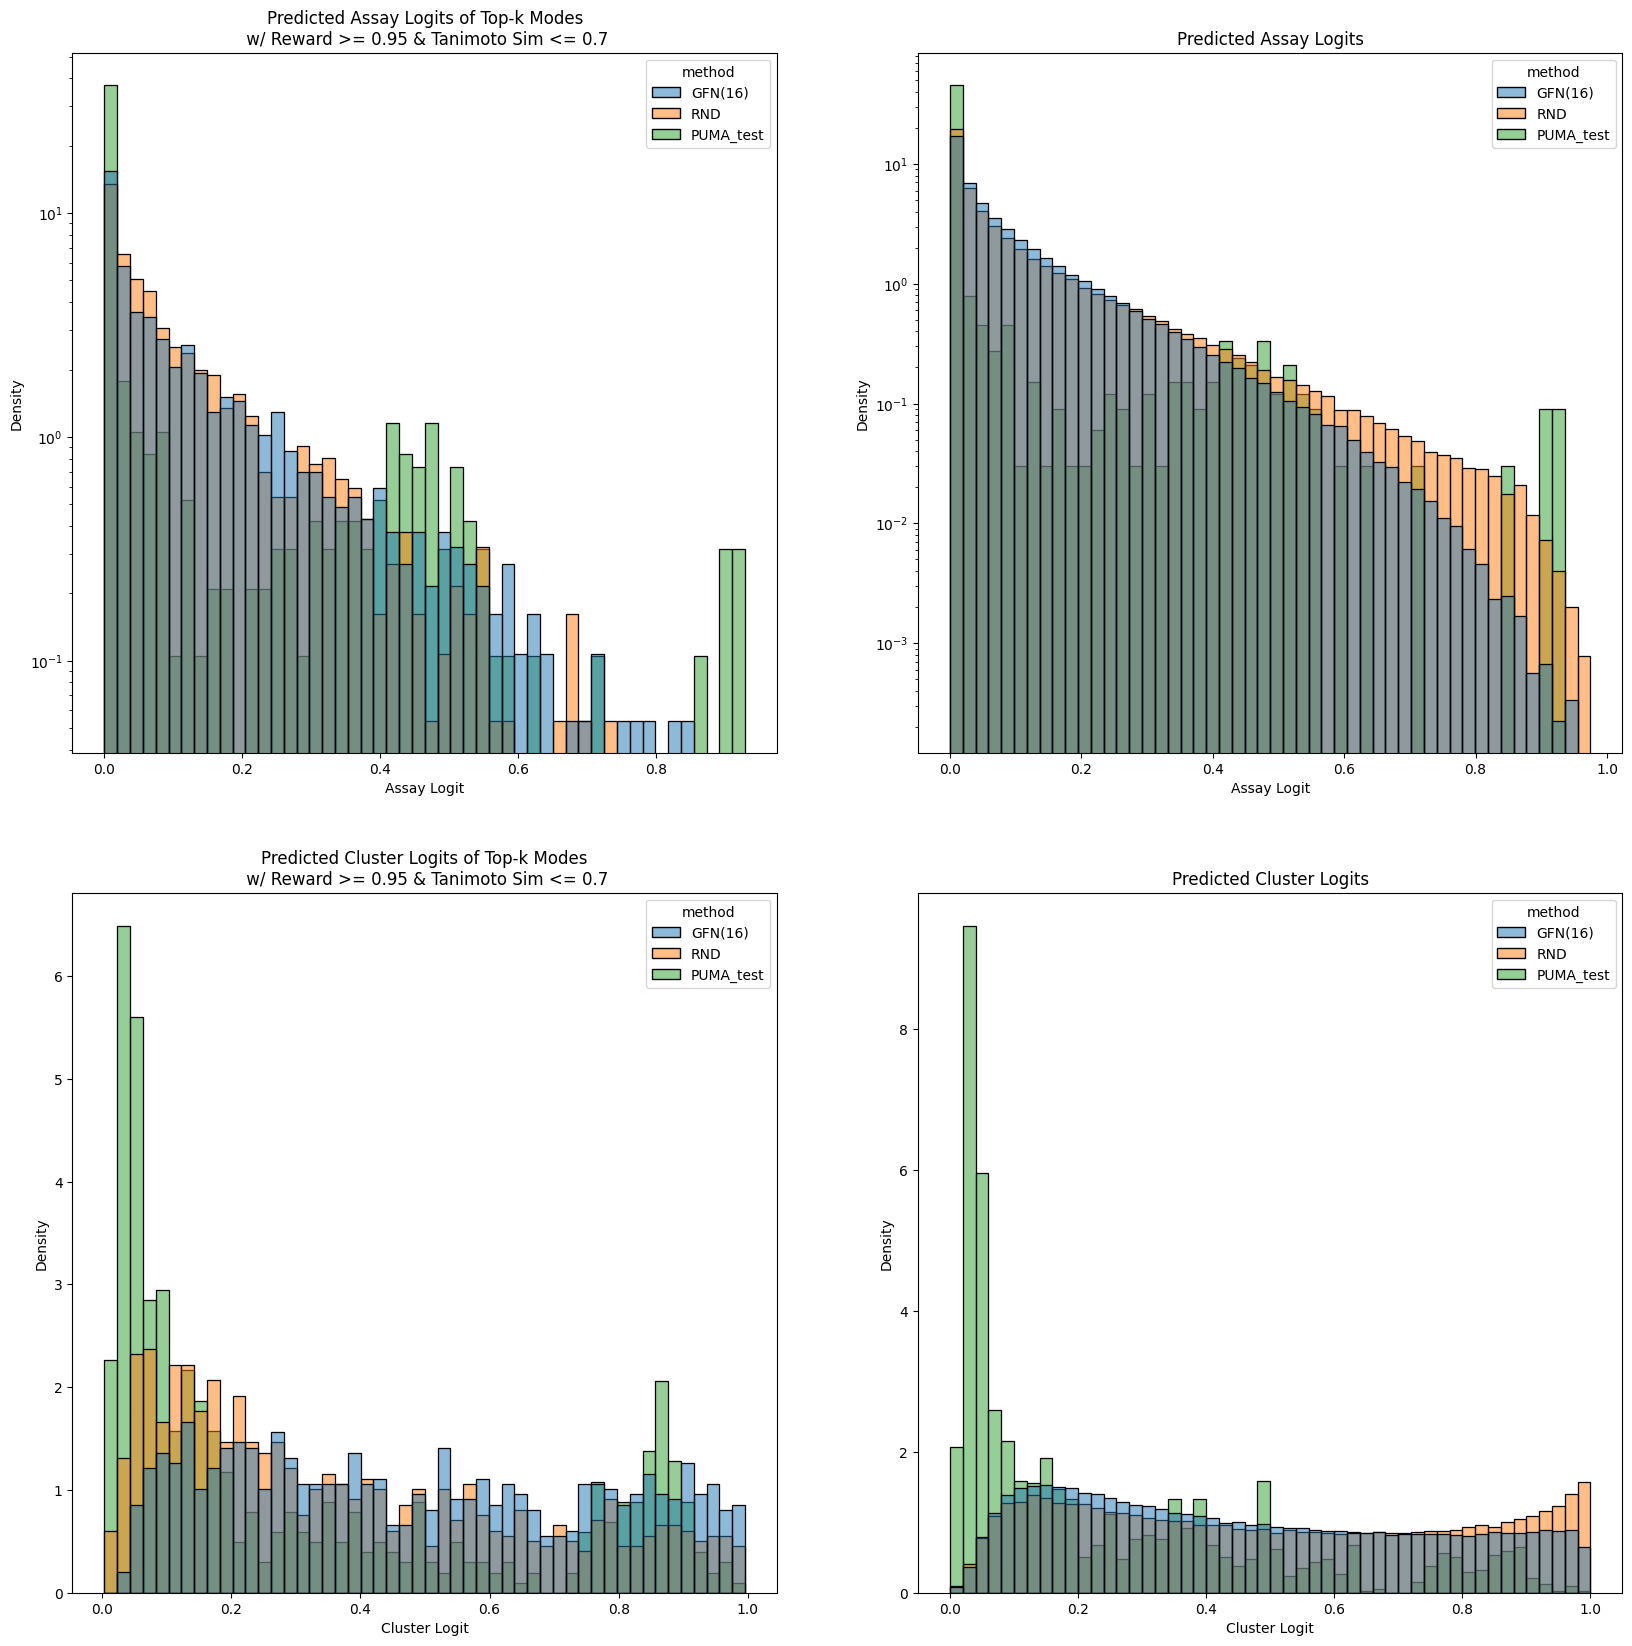

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
df1, df2 = pd.DataFrame(), pd.DataFrame()
for run_name, run_datum in runs_datum.items():
    if run_name in ["PUMA_tr", "PUMA_val", "GFN(0)", "GFN(1)", "GFN(32)"]: continue
    if "assay_preds" not in run_datum.keys(): continue
    top_k_modes_idx = find_modes_from_run_datum(run_datum, sim_threshold=1.0, k=1000)
    print(f"{run_name}: {len(top_k_modes_idx)}")
    df1 = pd.concat([df1, pd.DataFrame({
        "method": [run_name] * len(top_k_modes_idx),
        "assay_preds": run_datum['assay_preds'][top_k_modes_idx],
        "cluster_preds": run_datum['cluster_preds'][top_k_modes_idx],
    })])
    df2 = pd.concat([df2, pd.DataFrame({
        "method": [run_name] * len(run_datum['assay_preds']),
        "assay_preds": run_datum['assay_preds'],
        "cluster_preds": run_datum['cluster_preds'],
    })])

# df1_assays = df1[df1['assay_preds'] >= 0.5]
# df1_clusters = df1[df1['cluster_preds'] >= 0.5]

sns.histplot(data=df1, x="assay_preds", hue="method", bins=50, ax=ax[0,0], stat='density', alpha=0.5, common_norm=False)
sns.histplot(data=df2, x="assay_preds", hue="method", bins=50, ax=ax[0,1], stat='density', alpha=0.5, common_norm=False)
sns.histplot(data=df1, x="cluster_preds", hue="method", bins=50, ax=ax[1,0], stat='density', alpha=0.5, common_norm=False)
sns.histplot(data=df2, x="cluster_preds", hue="method", bins=50, ax=ax[1,1], stat='density', alpha=0.5, common_norm=False)

ax[0,1].set_title("Predicted Assay Logits")
ax[0,0].set_title("Predicted Assay Logits of Top-k Modes\n w/ Reward >= 0.95 & Tanimoto Sim <= 0.7")
ax[1,1].set_title("Predicted Cluster Logits")
ax[1,0].set_title("Predicted Cluster Logits of Top-k Modes\n w/ Reward >= 0.95 & Tanimoto Sim <= 0.7")
ax[0,0].set_xlabel("Assay Logit")
ax[0,1].set_xlabel("Assay Logit")
ax[1,0].set_xlabel("Cluster Logit")
ax[1,1].set_xlabel("Cluster Logit")
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
# ax[1,0].set_yscale('log')

plt.show()

Binning rewards into 11 bins between 0.21592676639556885 and 0.9779214262962341: 
Bins: [0.21592677 0.29212623 0.3683257  0.44452516 0.52072463 0.5969241
 0.67312356 0.74932303 0.82552249 0.90172196 0.97792143]
Sampling 250 samples per method per bin
Binning sim_to_target into 7 bins between 0.0 and 1.0: 
Bins: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
Sampling 250 samples per method per bin


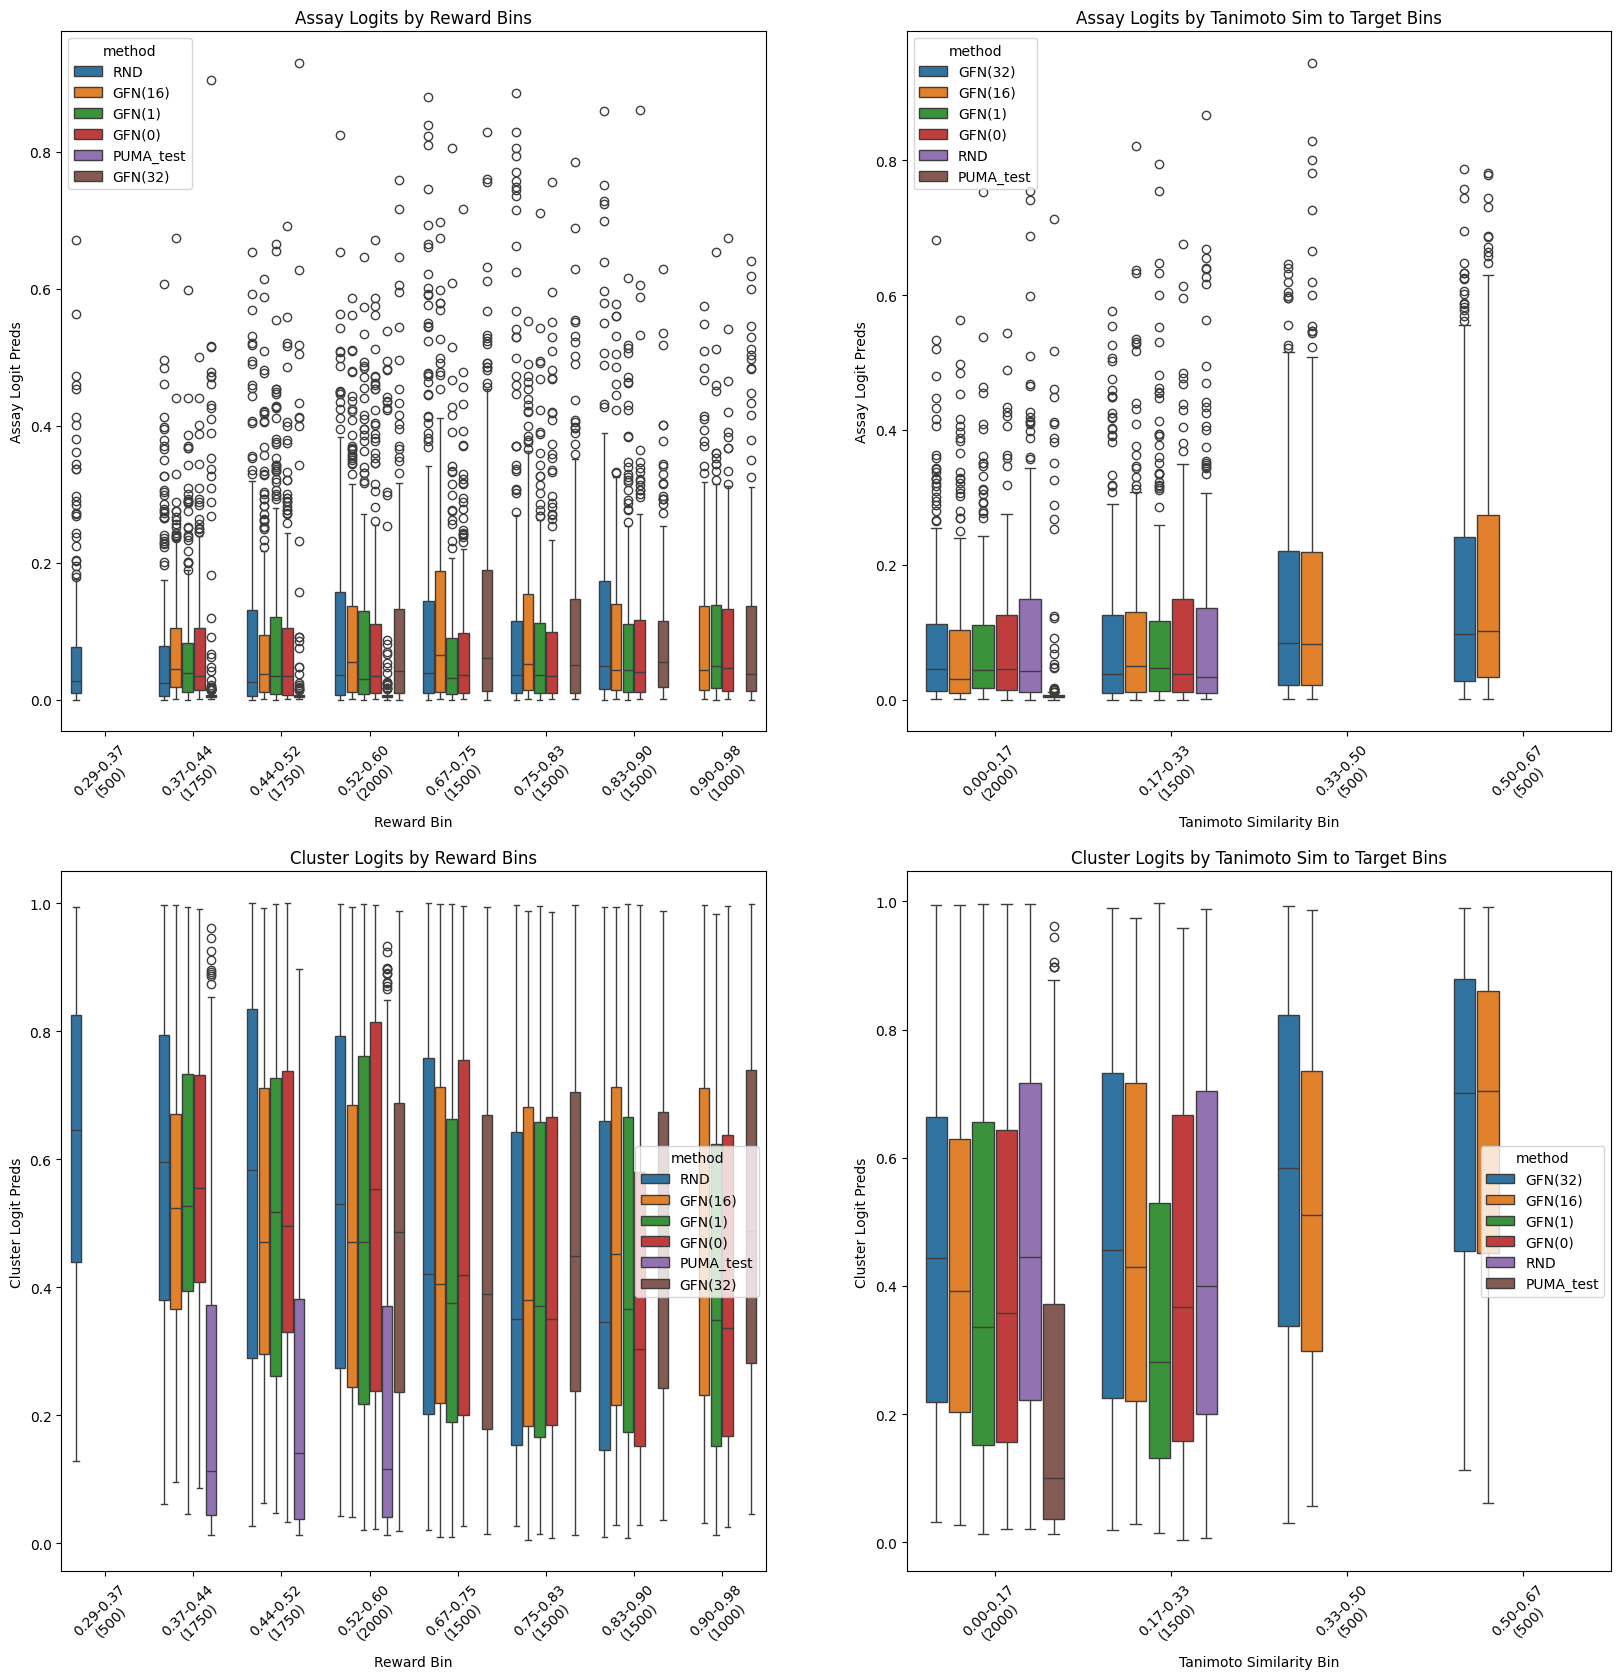

In [34]:
binned_datum_by_reward, rew_bins, rew_empty_bins, sper_rew_bin = bin_datum_by_col(
    "rewards", runs_datum, 11, return_bins=True, samples_per_method=250)
binned_datum_by_tan_sim, sim_bins, sim_empty_bins, sper_sim_bin = bin_datum_by_col(
    "sim_to_target", runs_datum, 7, return_bins=True, samples_per_method=250)
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
global_df_by_rew = pd.DataFrame()
global_df_by_sim = pd.DataFrame()

for run_name, run_datum in binned_datum_by_reward.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    # if run_name != "RND": continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    df["method"] = run_name
    global_df_by_rew = pd.concat([global_df_by_rew, df], ignore_index=True)

for run_name, run_datum in binned_datum_by_tan_sim.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    df["method"] = run_name
    global_df_by_sim = pd.concat([global_df_by_sim, df], ignore_index=True)

rew_bin_labels = [f"{rew_bins[i]:.2f}-{rew_bins[i+1]:.2f}\n({sper_rew_bin[i]})"
                    for i in range(len(rew_bins)-1)] + [f"{rew_bins[-1]:.2f}-1.0\n({sper_rew_bin[-1]})"]
sim_bin_labels = [f"{sim_bins[i]:.2f}-{sim_bins[i+1]:.2f}\n({sper_sim_bin[i]})"
                    for i in range(len(sim_bins)-1)] + [f"{sim_bins[-1]:.2f}-1.0\n({sper_sim_bin[-1]})"]

# Only keep the top 10 bins with values
rew_bins_ne = [i for i in range(1, len(rew_bins)+1) if i not in rew_empty_bins]
sim_bins_ne = [i for i in range(1, len(sim_bins)+1) if i not in sim_empty_bins]
rew_bins_to_keep = rew_bins_ne[:5] + rew_bins_ne[-5:]
sim_bins_to_keep = sim_bins_ne[:5] + sim_bins_ne[-5:]
global_df_by_rew = global_df_by_rew[global_df_by_rew['Bin'].isin(rew_bins_to_keep)]
global_df_by_sim = global_df_by_sim[global_df_by_sim['Bin'].isin(sim_bins_to_keep)]

sns.boxplot(x="Bin", y="assay_preds", hue="method", data=global_df_by_rew, ax=ax[0,0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)
sns.boxplot(x="Bin", y="assay_preds", hue="method", data=global_df_by_sim, ax=ax[0,1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

sns.boxplot(x="Bin", y="cluster_preds", hue="method", data=global_df_by_rew, ax=ax[1,0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)
sns.boxplot(x="Bin", y="cluster_preds", hue="method", data=global_df_by_sim, ax=ax[1,1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

ax[0,0].set_title("Assay Logits by Reward Bins")
ax[0,0].set_xlabel("Reward Bin")
ax[0,0].set_ylabel("Assay Logit Preds")
ax[0,0].xaxis.set_tick_params(rotation=45)
ax[0,1].set_title("Assay Logits by Tanimoto Sim to Target Bins")
ax[0,1].set_xlabel("Tanimoto Similarity Bin")
ax[0,1].set_ylabel("Assay Logit Preds")
ax[0,1].xaxis.set_tick_params(rotation=45)

ax[1,0].set_title("Cluster Logits by Reward Bins")
ax[1,0].set_xlabel("Reward Bin")
ax[1,0].set_ylabel("Cluster Logit Preds")
ax[1,0].xaxis.set_tick_params(rotation=45)
ax[1,1].set_title("Cluster Logits by Tanimoto Sim to Target Bins")
ax[1,1].set_xlabel("Tanimoto Similarity Bin")
ax[1,1].set_ylabel("Cluster Logit Preds")
ax[1,1].xaxis.set_tick_params(rotation=45)

plt.show()